# SDS 271 Final Project Prototype
Group 1 Christy Yang, Vicky Xu, Xinran Bi, Yuzhang Fu
### Intro

The prototype comprises essential functions intended for data manipulation and visualization. We conducted tests using the 'safelySanitication' file, creating plots that depict the population using safely managed sanitation services (%) for 'Total' at Period 2017. We investigated China's population using safely managed sanitation services over time, categorized by 'Total,' 'Urban,' and 'Rural.' Additionally, the create_heatmap function generates a choropleth map visualizing this value of 2017 worldwide.

In [1]:
import pandas as pd
import json
import branca.colormap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import Map, Choropleth, LegendControl
import geopandas as gpd
import branca.colormap
from ipywidgets import interactive_output
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_data(file_path):
    """loads data from the given file path"""
    data = pd.read_csv(file_path)
    return data

def check_same_entries_in_Indicator(data):
    """checks whether all entries in the 'Indicator' column are identical"""
    return data['Indicator'].nunique() == 1

def plot_first_tooltip_by_location(data, period, column_name=None,location=None):
    """
    Plot the value of "First Tooltip" for Dim1 = 'Total' at a designated period for different locations.
    In particular, if column_name is not provided and all entries in the 'Indicator' column are identical, 
    it uses the first entry in the 'Indicator' column as the column name. 
    If the 'Dim1' column includes categories 'Urban', 'Total', and 'Rural', the function proceeds with plotting; 
    otherwise, it notifies that the 'Dim1' column does not meet the specified criteria.
    """
    # Determine column name if not provided and all entries in 'Indicator' are identical
    if column_name is None and data['Indicator'].nunique() == 1:
        column_name = data['Indicator'].iloc[0]

    # Filter data for the specified period
    filtered_data = data[data['Period'] == period]

    # Filter data based on the specified location(s)
    if location is not None:
        if isinstance(location, str):
            location = [location]
        filtered_data = filtered_data[filtered_data['Location'].isin(location)]

    if 'Dim1' in data.columns and set(data['Dim1'].unique()) == {'Urban', 'Total', 'Rural'}:
        # Filter data for Dim1 categories 'Urban' and 'Rural'
        urban_rural_data = filtered_data[filtered_data['Dim1'].isin(['Urban', 'Rural'])]

        # Check if there's any data to plot
        if not urban_rural_data.empty:
            # Plotting for Urban and Rural categories side-by-side for each location
            unique_locations = urban_rural_data['Location'].unique()
            num_locations = len(unique_locations)

            fig, axes = plt.subplots(1, num_locations, figsize=(16, 6), sharey=True)
            fig.suptitle(f'{column_name} for Dim1 = Urban/Rural at Period {period}', fontsize=16)

            for i, loc in enumerate(unique_locations):
                loc_data = urban_rural_data[urban_rural_data['Location'] == loc]
                sns.barplot(x='Dim1', y='First Tooltip', data=loc_data, ax=axes[i])
                axes[i].set_title(f'Location: {loc}', fontsize=14)
                axes[i].set_xlabel('Dim1', fontsize=14)
                axes[i].set_ylabel(column_name, fontsize=14)

            plt.tight_layout()
            plt.show()
        else:
            print("No data available for the specified combination.")
    else:
        print("Dim1 column does not meet the specified criteria.")

In [3]:
def aggregate_data_by_region_and_year(data):
    # Define regions
    regions = {
        "AFR": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", "Central African Republic", "Chad", "Comoros", "Ivory Coast", "Democratic Republic of the Congo", "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique", "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "South Sudan", "Eswatini", "Togo", "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
        "AMR": ["Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Paraguay", "Peru", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "United States", "Uruguay", "Venezuela"],
        "SEAR": ["Bangladesh", "Bhutan", "North Korea", "India", "Indonesia", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"],
        "EUR": ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"],
        "EMR": ["Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran", "Iraq", "Palestine", "Jordan", "Kuwait", "Lebanon", "Libya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia", "Somalia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen"],
        "WPR": ["Australia", "Brunei", "Cambodia", "China", "Cook Islands", "Fiji", "Japan", "Kiribati", "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Samoa", "Singapore", "Solomon Islands", "South Korea", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam"]
    }

    # Create a DataFrame from the given data
    df = pd.DataFrame(data)

    # change Location from country to region
    df['Location'] = df['Location'].apply(lambda x: next((region for region, countries in regions.items() if x in countries), None))

    # Group by Region, Year, Dim1 and calculate the mean of 'First Tooltip'
    result_df = df.groupby(['Location', 'Indicator','Period', 'Dim1'])['First Tooltip'].mean().reset_index()

    return result_df


There're three functions offer different visualizations within the given dataframe. `lineplot` generates a line plot displaying the trend of the "First Tooltip'' over time for a designated location. `scatterplot` creates a scatter plot demonstrating the relationship between 'Period' and 'First Tooltip' for a specific location. Finally, `barplot` generates a bar plot illustrating the distribution of 'First Tooltip' values across various time periods ('Period') for a specified location within the dataframe. 

In [4]:
# lineplot
def lineplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df.Indicator[0]}", fontsize=14)
    plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()
    
# scatterplot
def scatterplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df.Indicator[0]}", fontsize=14)
    plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()

# barplot
def aggregate_years(df):
    aggregated_df = df.copy()
    
    # Aggregate years 2000-2005, 2006-2010, 2011-2017
    aggregated_df['Period'] = aggregated_df['Period'].astype(str) 
    
    aggregated_df.loc[aggregated_df['Period'].between('2000', '2005'), 'Period'] = '2000-2005'
    aggregated_df.loc[aggregated_df['Period'].between('2006', '2010'), 'Period'] = '2006-2010'
    aggregated_df.loc[aggregated_df['Period'].between('2011', '2017'), 'Period'] = '2011-2017'
    
    return aggregated_df

def barplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    df_location_aggregated = aggregate_years(df_location)
    
    # Define the desired order for the legend labels
    legend_order = ['2000-2005', '2006-2010', '2011-2017']
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_location_aggregated, x='Dim1', y='First Tooltip', hue='Period', hue_order=legend_order)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df_location_aggregated['Indicator'].iloc[0]}", fontsize=14)
    plt.legend(title='Year', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df_location_aggregated['Indicator'].iloc[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()

In [5]:
def create_health_map_multilayer(dataset, initial_year):
    # Create a slider widget for the year
    year_slider = widgets.IntSlider(value=initial_year, min=dataset['Period'].min(), max=dataset['Period'].max(), description='Year')
    
    # Load a GeoDataFrame with country boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create the initial map
    m = Map(center=(20, 0), zoom=2)
    display(m)
    
    # Initial empty Choropleth layer
    choro_layer = None  # Initialize with None
    
    def update_map(year):
        nonlocal choro_layer  # Use the outer variable

        # Filter for the specified year and dim1
        data_selected = dataset[(dataset['Period'] == year) & (dataset['Dim1'] == 'Total')]

        # Check if the filtered dataset is empty
        if data_selected.empty:
            # Print an error message
            print(f"No data available for the year {year} and dimension Total")
            return

        # Load a GeoDataFrame with country boundaries
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Merge the dataset with the GeoDataFrame
        merged = world.set_index('name').join(data_selected.set_index('Location'))

        # Define the color scale
        color_scale = branca.colormap.linear.YlOrRd_09.scale(merged['First Tooltip'].min(), merged['First Tooltip'].max())

        # Create a Choropleth layer
        choro_layer = Choropleth(
            geo_data=merged.__geo_interface__,
            choro_data=dict(merged['First Tooltip']),
            colormap=color_scale,
            style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
        )

        m.add_layer(choro_layer)
    
    # Set up an observer to update the map when the slider value changes
    output = interactive_output(update_map, {'year': year_slider})

    # Display the slider
    display(widgets.VBox([year_slider, output]))


In [6]:
def create_health_map(dataset, initial_year):
    # Create a slider widget for the year
    year_slider = widgets.IntSlider(value=initial_year, min=dataset['Period'].min(), max=dataset['Period'].max(), description='Year')
    
    # Load a GeoDataFrame with country boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create the initial map
    m = Map(center=(20, 0), zoom=2)
    display(m)
    # Initial empty Choropleth layer
    choro_layer = None
    def update_map(year):
        nonlocal choro_layer  # Use the outer variable

        # Clear existing Choropleth layer if it exists
        if choro_layer:
            m.remove_layer(choro_layer)
        
        # Filter for the specified year and dim1
        data_selected = dataset[(dataset['Period'] == year) & (dataset['Dim1'] == 'Total')]

        # Check if the filtered dataset is empty
        if data_selected.empty:
            # Print an error message
            print(f"No data available for the year {year} and dimension Total")
            return

        # Load a GeoDataFrame with country boundaries
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Merge the dataset with the GeoDataFrame
        merged = world.set_index('name').join(data_selected.set_index('Location'))

        # Define the color scale
        color_scale = branca.colormap.linear.YlOrRd_09.scale(merged['First Tooltip'].min(), merged['First Tooltip'].max())

        # Create a Choropleth layer
        choro_layer = Choropleth(
            geo_data=merged.__geo_interface__,
            choro_data=dict(merged['First Tooltip']),
            colormap=color_scale,
            style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
        )

        m.add_layer(choro_layer)
    
    # Set up an observer to update the map when the slider value changes
    output = interactive_output(update_map, {'year': year_slider})

    # Display the slider
    display(widgets.VBox([year_slider, output]))

We test our functions using 'safelySanitization.csv', focusing on the key indicator: the percentage of the population using safe sanitation services.

In [7]:
file_path = "data/safelySanitization.csv"
health_data = load_data(file_path)
health_data.head()

,Location,Indicator,Period,Dim1,First Tooltip
0,Albania,Population using safely managed sanitation ser...,2017,Total,39.86
1,Albania,Population using safely managed sanitation ser...,2017,Urban,40.17
2,Albania,Population using safely managed sanitation ser...,2017,Rural,39.39
3,Albania,Population using safely managed sanitation ser...,2016,Total,39.85
4,Albania,Population using safely managed sanitation ser...,2016,Urban,40.17


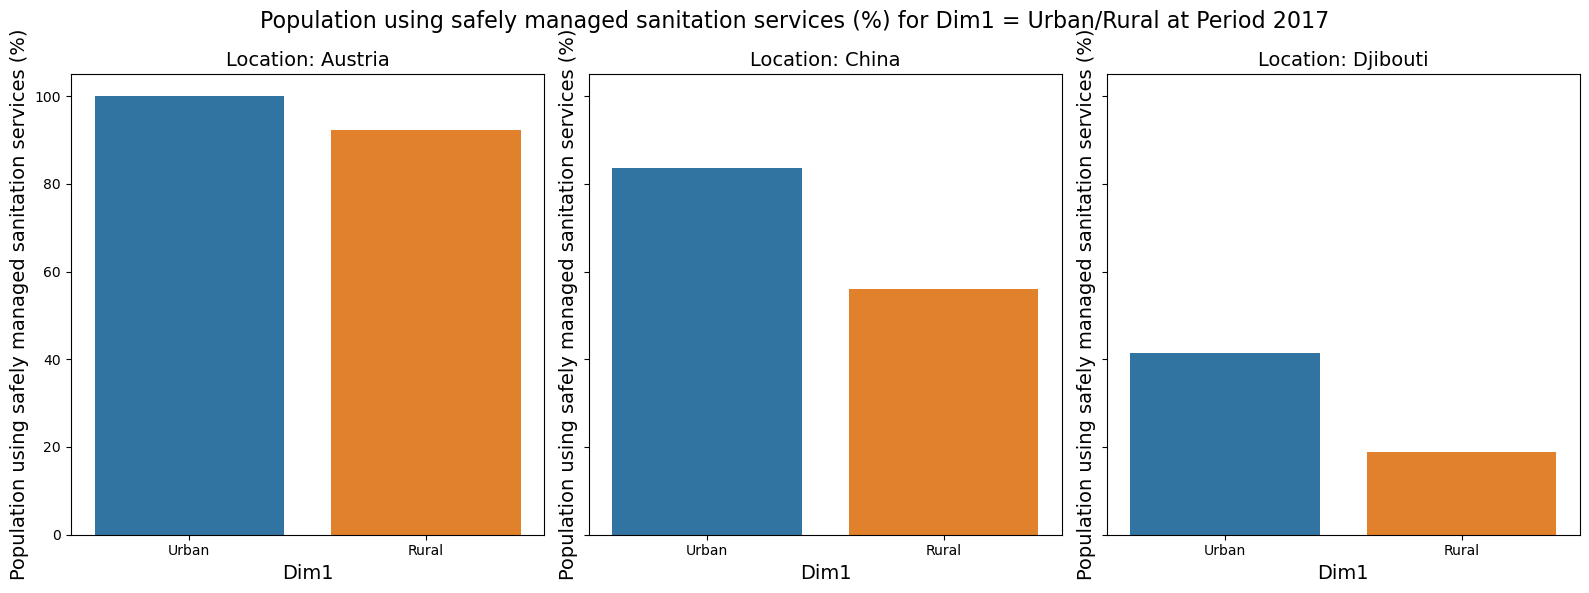

In [8]:
plot_first_tooltip_by_location(health_data, 2017, None, ["China","Austria","Djibouti"])

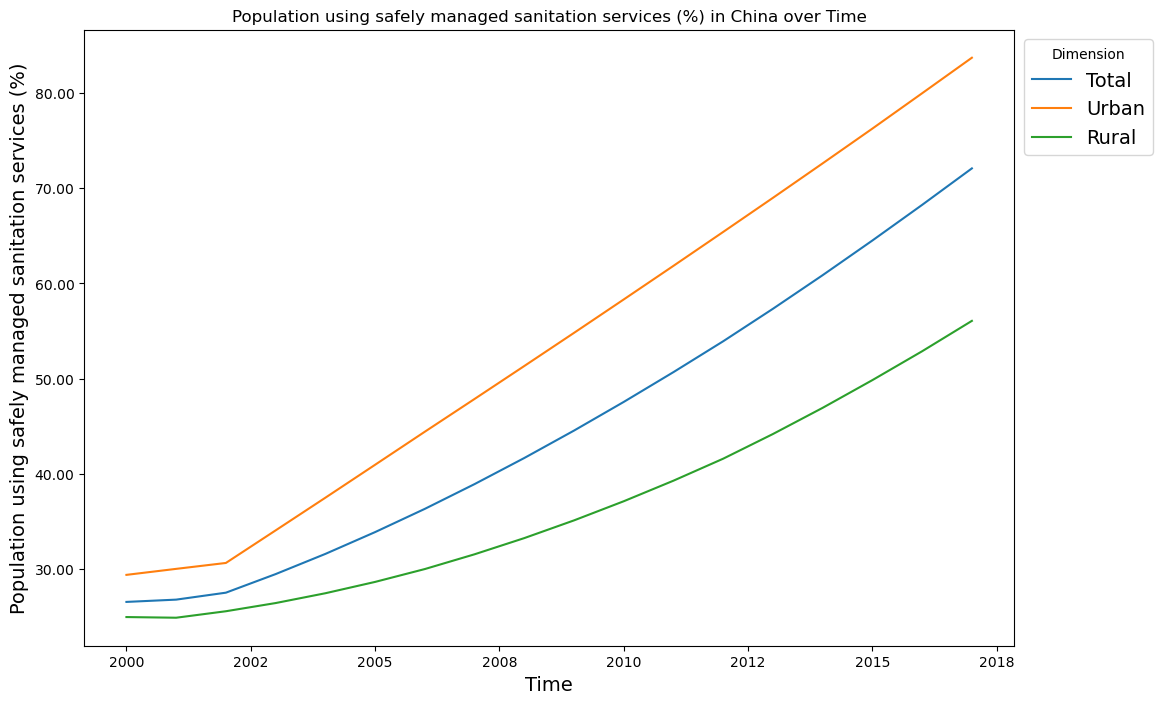

In [9]:
lineplot(health_data, "China")

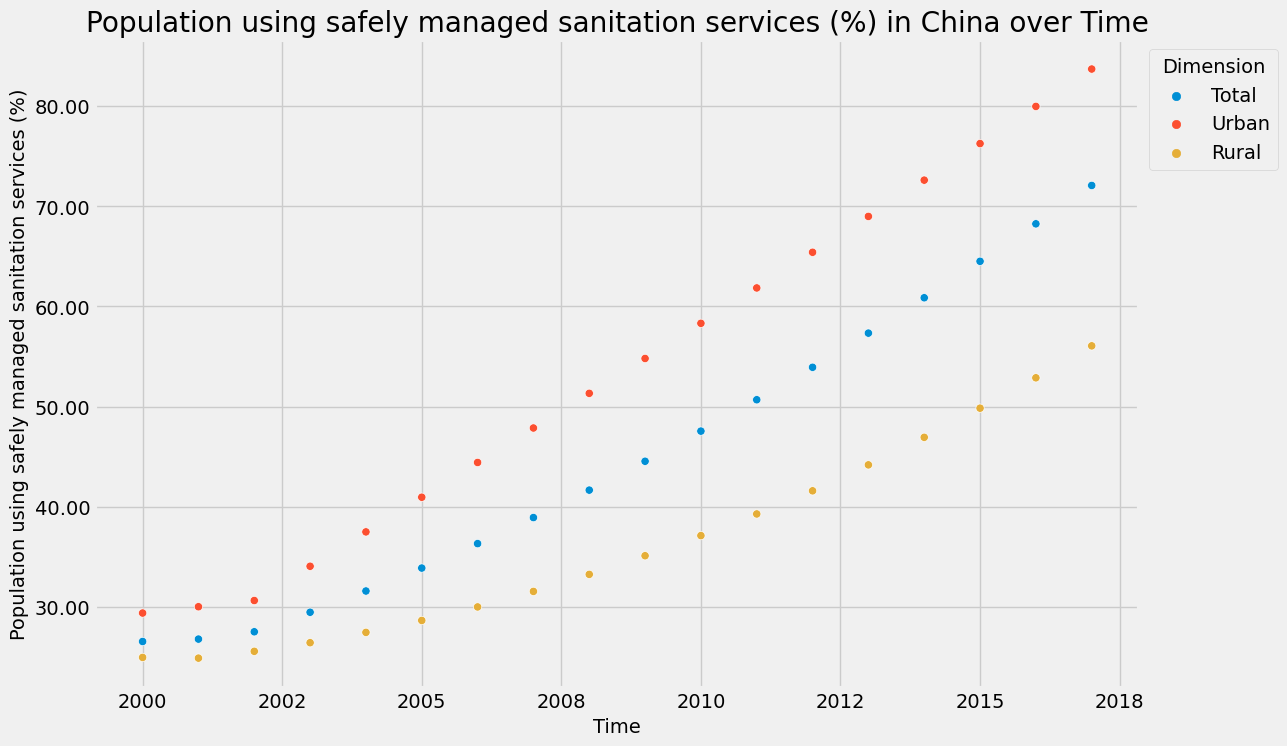

In [10]:
scatterplot(health_data, "China")

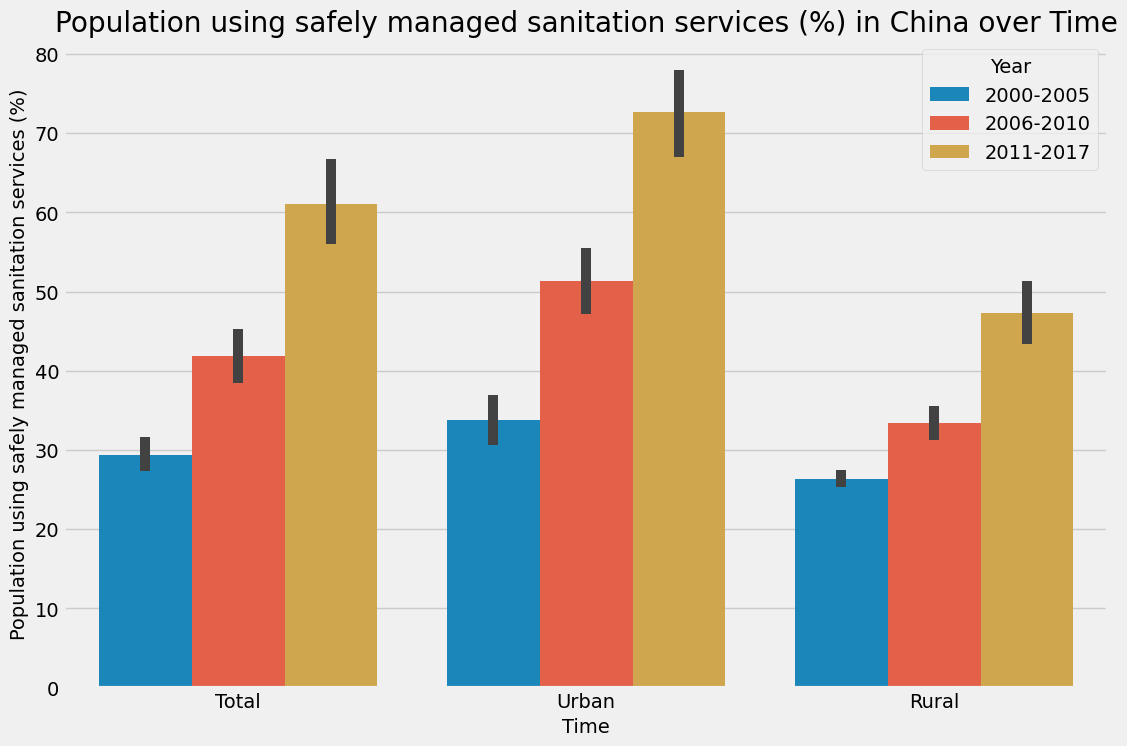

In [11]:
barplot(health_data, "China")

In [12]:
create_health_map_multilayer(dataset=health_data, initial_year=2013)

/var/folders/6w/l001bs1j6x191sbj81x2jq640000gn/T/ipykernel_35218/2469158146.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [13]:
create_health_map(dataset=health_data, initial_year=2013)

No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 8e41b3a4d9734f65a2a1721ce4fca5c0
No such comm: 967d41b8dcbc4ae4b31f3f032f500d7b
/var/folders/6w/l001bs1j6x191sbj81x2jq640000gn/T/ipykernel_35218/1493265597.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be re

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [14]:
health_data_by_region = aggregate_data_by_region_and_year(health_data)
health_data_by_region.head()

,Location,Indicator,Period,Dim1,First Tooltip
0,AFR,Population using safely managed sanitation ser...,2000,Rural,9.173750
1,AFR,Population using safely managed sanitation ser...,2000,Total,12.785000
2,AFR,Population using safely managed sanitation ser...,2000,Urban,16.948571
3,AFR,Population using safely managed sanitation ser...,2001,Rural,9.507500
4,AFR,Population using safely managed sanitation ser...,2001,Total,13.041667


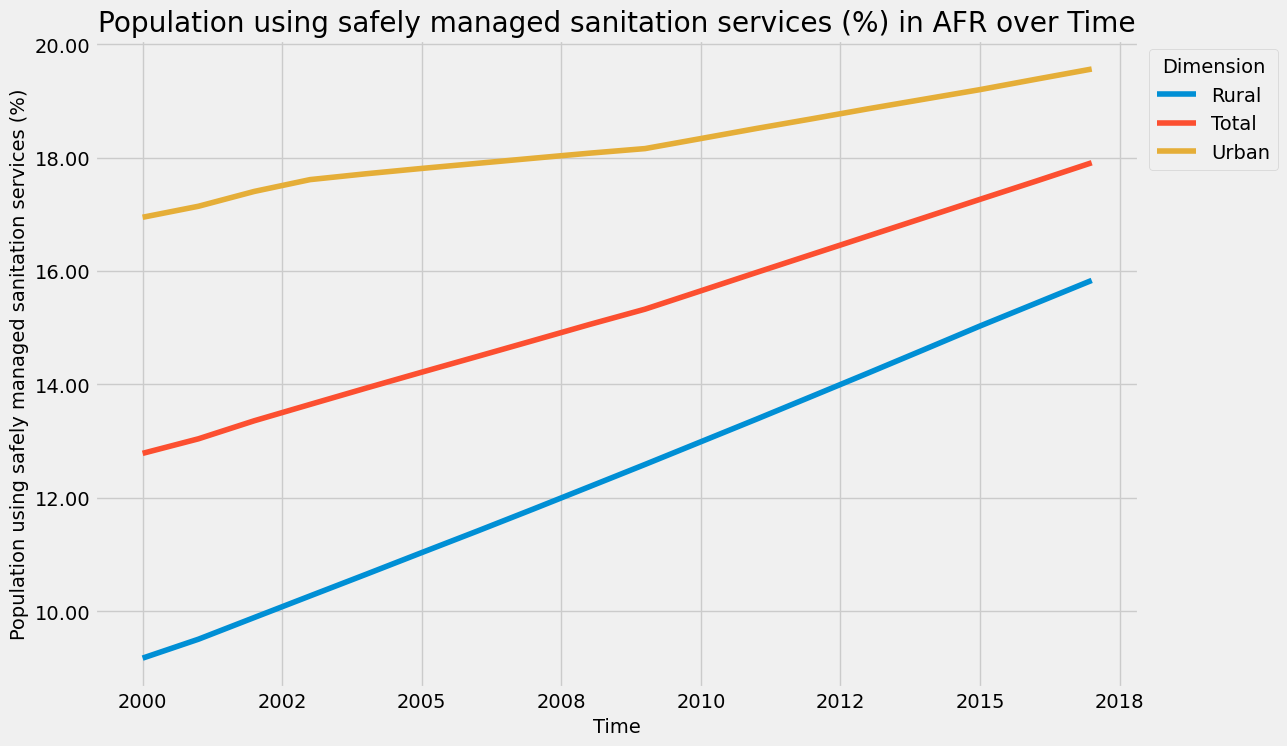

In [15]:
lineplot(health_data_by_region, "AFR")

## Reflection:


We implemented the geomap while it failed to show up in the jupyter notebook. So our next step would be to figure out how to display map as a function in a function way as a python package.
We want to explore other potential graphs that can help the user consume raw data and provide additional insights. For instance, a user can have two csv files read in and compare how one factor affects the other by visualizations. 
Another important thing to address is we want to first validate the form of the csv file the package reads in. For instance, it at least has to have three columns that are respectively location, time periods and the corresponding value. So we want to implement an error handling function to filter out those csv that don't meet the criteria. 
Lastly, the current graphs don't have the best aesthetics and we want to refine them.